In [1]:
import numpy as np
import scipy as sp
import scipy.stats
import itertools
import logging
import matplotlib.pyplot as plt
import pandas as pd
import torch.utils.data as utils
import math
import time
import tqdm

import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal

import torch.nn as nn
import torch.nn.init as init

from flows import RealNVP
from models import NormalizingFlowModel

## Build the model

In [2]:
class PlanarFlow(nn.Module):
    def __init__(self, D):
        super().__init__()
        self.D = D

    def forward(self, z, lamda):
        '''
        z - latents from prev layer
        lambda - Flow parameters (b, w, u)
        b - scalar
        w - vector
        u - vector
        '''
        b = lamda[:, :1]
        w, u = lamda[:, 1:].chunk(2, dim=1)

        # Forward
        # f(z) = z + u tanh(w^T z + b)
        transf = F.tanh(
            z.unsqueeze(1).bmm(w.unsqueeze(2))[:, 0] + b
        )
        f_z = z + u * transf

        # Inverse
        # psi_z = tanh' (w^T z + b) w
        psi_z = (1 - transf ** 2) * w
        log_abs_det_jacobian = torch.log(
            (1 + psi_z.unsqueeze(1).bmm(u.unsqueeze(2))).abs()
        )

        return f_z, log_abs_det_jacobian

In [3]:
class NormalizingFlow(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.flows = nn.ModuleList([PlanarFlow(D) for i in range(K)])

    def forward(self, z_k, flow_params):
        # ladj -> log abs det jacobian
        sum_ladj = 0
        for i, flow in enumerate(self.flows):
            z_k, ladj_k = flow(z_k, flow_params[i])
            sum_ladj += ladj_k

        return z_k, sum_ladj

In [4]:
class VAE_NF(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.dim = D
        self.K = K
        self.encoder = nn.Sequential(
            nn.Linear(22, 96),
            nn.LeakyReLU(True),
            nn.Linear(96, 48),
            nn.LeakyReLU(True),            
            nn.Linear(48, D * 2 + K * (D * 2 + 1))
        )

        self.decoder = nn.Sequential(
            nn.Linear(D, 48),
            nn.LeakyReLU(True),
            nn.Linear(48, 96),
            nn.LeakyReLU(True),
            nn.Linear(96, 22),
            nn.Sigmoid()
        )

        self.flows = NormalizingFlow(K, D)

    def forward(self, x):
        # Run Encoder and get NF params
        enc = self.encoder(x)
        mu = enc[:, :self.dim]
        log_var = enc[:, self.dim: self.dim * 2]
        flow_params = enc[:, 2 * self.dim:].chunk(self.K, dim=1)

        # Re-parametrize
        sigma = (log_var * .5).exp()
        z = mu + sigma * torch.randn_like(sigma)
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # Construct more expressive posterior with NF
        z_k, sum_ladj = self.flows(z, flow_params)
        kl_div = kl_div / x.size(0) - sum_ladj.mean()  # mean over batch

        # Run Decoder
        x_prime = self.decoder(z_k)
        return x_prime, kl_div

In [5]:
BATCH_SIZE = 1000
N_EPOCHS = 80
PRINT_INTERVAL = 2000
NUM_WORKERS = 4
LR = 1e-4
MODEL = 'VAE-NF'  # VAE-NF | VAE

N_FLOWS = 2
Z_DIM = 3

n_steps = 0

In [6]:
if MODEL == 'VAE-NF':
    model = VAE_NF(N_FLOWS, Z_DIM).cuda()
else:
    model = VAE(Z_DIM).cuda()

## Testing with the trained model on signal

In [7]:
model.load_state_dict(torch.load("lhc_weights/original_signal_900_vae_NF_planar.h5"))

<All keys matched successfully>

In [8]:
def get_mass_and_loss(inputstring):
    f_in = pd.read_hdf(inputstring)
    dt_in = f_in.values
    dt_in[:,1] = (dt_in[:,1]-np.mean(dt_in[:,1]))/np.std(dt_in[:,1])
    dt_in[:,2] = (dt_in[:,2]-np.mean(dt_in[:,2]))/np.std(dt_in[:,2])
    dt_in[:,3] = (dt_in[:,3]-np.mean(dt_in[:,3]))/np.std(dt_in[:,3])
    dt_in[:,4] = (dt_in[:,4]-np.mean(dt_in[:,4]))/np.std(dt_in[:,4])
    dt_in[:,5] = (dt_in[:,5]-np.mean(dt_in[:,5]))/np.std(dt_in[:,5])
    dt_in[:,6] = (dt_in[:,6]-np.mean(dt_in[:,6]))/np.std(dt_in[:,6])

    dt_in[:,8] = (dt_in[:,8]-np.mean(dt_in[:,8]))/np.std(dt_in[:,8])
    dt_in[:,9] = (dt_in[:,9]-np.mean(dt_in[:,9]))/np.std(dt_in[:,9])
    dt_in[:,10] = (dt_in[:,10]-np.mean(dt_in[:,10]))/np.std(dt_in[:,10])
    dt_in[:,11] = (dt_in[:,11]-np.mean(dt_in[:,11]))/np.std(dt_in[:,11])
    dt_in[:,12] = (dt_in[:,12]-np.mean(dt_in[:,12]))/np.std(dt_in[:,12])

    dt_in[:,14] = (dt_in[:,14]-np.mean(dt_in[:,14]))/np.std(dt_in[:,14])
    dt_in[:,15] = (dt_in[:,15]-np.mean(dt_in[:,15]))/np.std(dt_in[:,15])
    dt_in[:,16] = (dt_in[:,16]-np.mean(dt_in[:,16]))/np.std(dt_in[:,16])
    dt_in[:,17] = (dt_in[:,17]-np.mean(dt_in[:,17]))/np.std(dt_in[:,17])
    dt_in[:,18] = (dt_in[:,18]-np.mean(dt_in[:,18]))/np.std(dt_in[:,18])
    dt_in[:,19] = (dt_in[:,19]-np.mean(dt_in[:,19]))/np.std(dt_in[:,19])
    
    dt_in[:,21] = (dt_in[:,21]-np.mean(dt_in[:,21]))/np.std(dt_in[:,21])
    dt_in[:,22] = (dt_in[:,22]-np.mean(dt_in[:,22]))/np.std(dt_in[:,22])
    dt_in[:,23] = (dt_in[:,23]-np.mean(dt_in[:,23]))/np.std(dt_in[:,23])
    dt_in[:,24] = (dt_in[:,24]-np.mean(dt_in[:,24]))/np.std(dt_in[:,24])
    dt_in[:,25] = (dt_in[:,25]-np.mean(dt_in[:,25]))/np.std(dt_in[:,25])


    
    
    total_in = torch.tensor(dt_in)
    total_in_train_x_1 = total_in.t()[1:7].t()
    total_in_train_x_2 = total_in.t()[8:13].t()
    total_in_train_x_3 = total_in.t()[14:20].t()
    total_in_train_x_4 = total_in.t()[21:26].t()
    total_in_selection = torch.cat((total_in_train_x_1,total_in_train_x_2,total_in_train_x_3,total_in_train_x_4),dim=1)
    
    loss_total_in = torch.mean((model(total_in_selection.float().cuda())[0]-
                       total_in_selection.float().cuda())**2,dim=1).data.cpu().numpy()
    
    f_in = pd.read_hdf(inputstring)
    dt_in = f_in.values
    
    return dt_in[:,0], dt_in[:,10], dt_in[:,23], dt_in[:,9], dt_in[:,22], loss_total_in

In [9]:
diluted_mass, diluted_mmdt1, diluted_mmdt2, diluted_prun1,diluted_prun2, diluted_loss = get_mass_and_loss("../../../2_lhc/LHC_Olympics2020/processing/test_dataset/MassRatio_RandD_diluted_10k.h5")
puresigmass, puresigmmdt1, puresigmmdt2, puresigprun1,puresigprun2, puresigloss = get_mass_and_loss("../../../2_lhc/LHC_Olympics2020/processing/test_dataset/MassRatio_RandD_signal_900.h5")

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [10]:
idx_signal = np.where(diluted_loss<0.65)

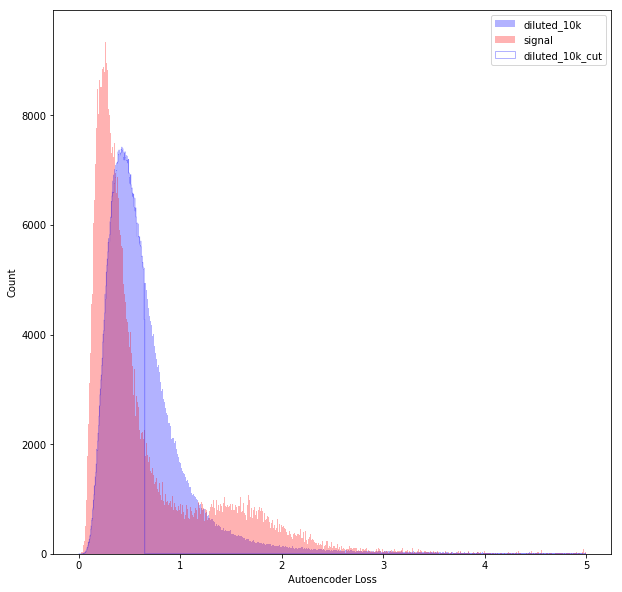

In [11]:
plt.rcParams["figure.figsize"] = (10,10)
bins = np.linspace(0,5,1100)
plt.hist(diluted_loss,bins=bins,alpha=0.3,color='b',label='diluted_10k')
plt.hist(puresigloss,bins=bins,alpha=0.3,color='r',label='signal',weights=np.ones(len(puresigloss))*11.22)
plt.hist(diluted_loss[idx_signal],bins=bins,alpha=0.3,color='b',label='diluted_10k_cut',histtype="step")
plt.xlabel(r'Autoencoder Loss')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.show()

In [12]:
len(diluted_loss)/len(puresigloss)

11.222222222222221

In [13]:
min(diluted_loss[idx_signal]),max(diluted_loss[idx_signal])

(0.02354719, 0.6499999)

In [14]:
len(idx_signal[0])

623245

## Testing with the trained model on bkg

In [15]:
model.load_state_dict(torch.load("lhc_weights/original_bkg_vae_NF_planar.h5"))

<All keys matched successfully>

In [16]:
def get_mass_and_loss(inputstring):
    f_in = pd.read_hdf(inputstring)
    dt_in = f_in.values
    dt_in[:,1] = (dt_in[:,1]-np.mean(dt_in[:,1]))/np.std(dt_in[:,1])
    dt_in[:,2] = (dt_in[:,2]-np.mean(dt_in[:,2]))/np.std(dt_in[:,2])
    dt_in[:,3] = (dt_in[:,3]-np.mean(dt_in[:,3]))/np.std(dt_in[:,3])
    dt_in[:,4] = (dt_in[:,4]-np.mean(dt_in[:,4]))/np.std(dt_in[:,4])
    dt_in[:,5] = (dt_in[:,5]-np.mean(dt_in[:,5]))/np.std(dt_in[:,5])
    dt_in[:,6] = (dt_in[:,6]-np.mean(dt_in[:,6]))/np.std(dt_in[:,6])

    dt_in[:,8] = (dt_in[:,8]-np.mean(dt_in[:,8]))/np.std(dt_in[:,8])
    dt_in[:,9] = (dt_in[:,9]-np.mean(dt_in[:,9]))/np.std(dt_in[:,9])
    dt_in[:,10] = (dt_in[:,10]-np.mean(dt_in[:,10]))/np.std(dt_in[:,10])
    dt_in[:,11] = (dt_in[:,11]-np.mean(dt_in[:,11]))/np.std(dt_in[:,11])
    dt_in[:,12] = (dt_in[:,12]-np.mean(dt_in[:,12]))/np.std(dt_in[:,12])

    dt_in[:,14] = (dt_in[:,14]-np.mean(dt_in[:,14]))/np.std(dt_in[:,14])
    dt_in[:,15] = (dt_in[:,15]-np.mean(dt_in[:,15]))/np.std(dt_in[:,15])
    dt_in[:,16] = (dt_in[:,16]-np.mean(dt_in[:,16]))/np.std(dt_in[:,16])
    dt_in[:,17] = (dt_in[:,17]-np.mean(dt_in[:,17]))/np.std(dt_in[:,17])
    dt_in[:,18] = (dt_in[:,18]-np.mean(dt_in[:,18]))/np.std(dt_in[:,18])
    dt_in[:,19] = (dt_in[:,19]-np.mean(dt_in[:,19]))/np.std(dt_in[:,19])
    
    dt_in[:,21] = (dt_in[:,21]-np.mean(dt_in[:,21]))/np.std(dt_in[:,21])
    dt_in[:,22] = (dt_in[:,22]-np.mean(dt_in[:,22]))/np.std(dt_in[:,22])
    dt_in[:,23] = (dt_in[:,23]-np.mean(dt_in[:,23]))/np.std(dt_in[:,23])
    dt_in[:,24] = (dt_in[:,24]-np.mean(dt_in[:,24]))/np.std(dt_in[:,24])
    dt_in[:,25] = (dt_in[:,25]-np.mean(dt_in[:,25]))/np.std(dt_in[:,25])


    
    
    total_in = torch.tensor(dt_in)
    total_in_train_x_1 = total_in.t()[1:7].t()
    total_in_train_x_2 = total_in.t()[8:13].t()
    total_in_train_x_3 = total_in.t()[14:20].t()
    total_in_train_x_4 = total_in.t()[21:26].t()
    total_in_selection = torch.cat((total_in_train_x_1,total_in_train_x_2,total_in_train_x_3,total_in_train_x_4),dim=1)
    
    loss_total_in = torch.mean((model(total_in_selection.float().cuda())[0]-
                       total_in_selection.float().cuda())**2,dim=1).data.cpu().numpy()
    
    f_in = pd.read_hdf(inputstring)
    dt_in = f_in.values
    
    return dt_in[:,0], dt_in[:,10], dt_in[:,23], dt_in[:,9], dt_in[:,22], loss_total_in

In [17]:
diluted_mass, diluted_mmdt1, diluted_mmdt2, diluted_prun1,diluted_prun2, diluted_loss = get_mass_and_loss("../../../2_lhc/LHC_Olympics2020/processing/test_dataset/MassRatio_RandD_diluted_10k.h5")
purebkgmass, purebkgmmdt1, purebkgmmdt2, purebkgprun1,purebkgprun2, purebkgloss = get_mass_and_loss("../../../2_lhc/LHC_Olympics2020/processing/test_dataset/MassRatio_pureBkg.h5")

In [18]:
idx_bkg = np.where(diluted_loss>2)

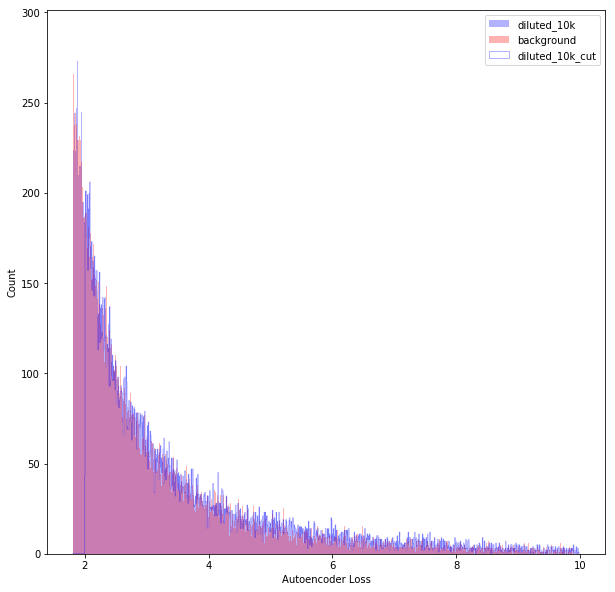

In [19]:
plt.rcParams["figure.figsize"] = (10,10)
bins = np.linspace(1.8,10,1100)
plt.hist(diluted_loss,bins=bins,alpha=0.3,color='b',label='diluted_10k')
plt.hist(purebkgloss,bins=bins,alpha=0.3,color='r',label='background',weights=np.ones(len(purebkgloss))*1.01)
plt.hist(diluted_loss[idx_bkg],bins=bins,alpha=0.3,color='b',label='diluted_10k_cut',histtype="step")
plt.xlabel(r'Autoencoder Loss')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.show()

In [20]:
len(diluted_loss)/len(purebkgloss)

1.01

In [22]:
len(idx_bkg[0])

28057

In [23]:
idx = np.intersect1d(idx_bkg,idx_signal)
idx

array([], dtype=int64)

## Plot remained data in BB

In [ ]:
bb_data = pd.read_hdf("../../../2_lhc/LHC_Olympics2020/processing/test_dataset/MassRatio_RandD_diluted_10k.h5")
bb_data = bb_data.values

In [ ]:
good_data = bb_data[idx]
mjj_good_data = good_data[:,0]

In [ ]:
plt.hist(mjj_good_data,100);